# Twitter API

First of all we make the conection to an app created in twitter development, please have in mind that is mandatory to upload the location path of the credentials where we have the keys to make the connection to the created app. This credentials are placed in the twitter.txt file. 

In [1]:
import logging
import sys
import pandas as pd
import time
from configparser import ConfigParser
from twython import Twython, TwythonRateLimitError
from wordcloud import WordCloud
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import re

#Creates a log file of the conection
logging.basicConfig(filename='TwitterSNA.log',level=logging.DEBUG)
logging.info('INICIO')


config = ConfigParser()
config.read('twitter.txt') #Colocar ruta con el archivo txt
APP_KEY = config.get('credentials','app_key')
APP_SECRET = config['credentials']['app_secret']
twitter = Twython(APP_KEY, APP_SECRET, oauth_version=2)
ACCESS_TOKEN =twitter.obtain_access_token()
twitter = Twython(APP_KEY, access_token=ACCESS_TOKEN)


Then we create the code to feed the dataframe, we define a limit of 1.000 tweets to the query and it download more than 1.000 depending the mentions the tweet has. It is necessary to determine the hashtag and the API get us a mix of popular and most recent tweets of the hashtag we are looking for. 

In [2]:
tweet_query_size = 1000
next_max_id     = -1
tweet_list_ids = []
first_time = True
hashtag= '#TSLA'

def wait_for_awhile():
    reset = int(twitter.get_lastfunction_header('x-rate-limit-reset'))
    wait = max(reset - time.time(),0) + 10
    print("Rate limit exceeded waiting: %s %0.0fs" %
             (int(int( wait)/60),wait % 60 ))
    time.sleep(wait)

columnas=['screen_name','user_id','user_followers_count','tweet_id','mention_screen_name','texto','created_date']
df=pd.DataFrame(columns=columnas)
lista=[]
    
while (len(tweet_list_ids) < tweet_query_size):
    try:
        print("Tweets %s to %s: cursor: %s" % 
                (len(tweet_list_ids), len(tweet_list_ids) + 100, next_max_id))

        result = twitter.search(q=hashtag, count = 100, max_id=next_max_id, lang='en')
        for tw in result['statuses']:
                if (first_time == True):
                    first_time = False
                    next_max_id = tw['id']
                if tw['id'] not in tweet_list_ids:
                    tweet_list_ids.append(tw['id'])
                    next_max_id = min(tw['id'], next_max_id)
                    retweet = False
                    retweet_user = 'NA'
                    mention = 'NA'
                    if 'retweeted_status' in tw:
                        retweet = True
                        retweet_user = tw['retweeted_status']['user']['screen_name']
                    if (len(tw['entities']['user_mentions']) == 0):
                        a_series = pd.Series([tw['user']['screen_name'], 
                                                tw['user']['id'],
                                                tw['user']['followers_count'], 
                                                tw['id'],
                                                'NA',
                                                tw['text'], #.encode('utf-8').strip(), 
                                                tw['created_at']], index = df.columns)
                        df=df.append(a_series, ignore_index=True)
                    
                    else:
                        for mention in tw['entities']['user_mentions']:
                            a_series = pd.Series([tw['user']['screen_name'], 
                                                tw['user']['id'],
                                                tw['user']['followers_count'], 
                                                tw['id'], 
                                                mention['screen_name'],
                                                tw['text'], #.encode('utf-8').strip(),
                                                tw['created_at']], index = df.columns)
                            df=df.append(a_series, ignore_index=True)
                    
    #except:
    #    print("something went wrong")
    except TwythonRateLimitError as e:
        wait_for_awhile()
    except:    
        print(" Failed: Unexpected error:", sys.exc_info()[0])    

Tweets 0 to 100: cursor: -1
Tweets 78 to 178: cursor: 1529715849988149248
Tweets 127 to 227: cursor: 1529616126363115520
Tweets 173 to 273: cursor: 1529558325058277376
Tweets 215 to 315: cursor: 1529516379216306177
Tweets 269 to 369: cursor: 1529467891363586051
Tweets 276 to 376: cursor: 1529460723910430720
Tweets 340 to 440: cursor: 1529381571546980352
Tweets 355 to 455: cursor: 1529353580867915776
Tweets 423 to 523: cursor: 1529286679902965760
Tweets 428 to 528: cursor: 1529271322450305024
Tweets 480 to 580: cursor: 1529206196774785030
Tweets 579 to 679: cursor: 1529146576907563008
Tweets 675 to 775: cursor: 1529094440505290754
Tweets 763 to 863: cursor: 1528942223630290944
Tweets 857 to 957: cursor: 1528851107539451904
Tweets 938 to 1038: cursor: 1528764975195488256


In [3]:
df.head(10)
#df.to_csv('tweets_prueba.csv')

,screen_name,user_id,user_followers_count,tweet_id,mention_screen_name,texto,created_date
0,VinCheng,89485830,30,1529809644318769158,StocksAfterDark,RT @StocksAfterDark: $TSLA - Pushed⬆️in PM. 8⃣...,Thu May 26 13:00:16 +0000 2022
1,topstonks,1214957598073589760,3241,1529809071871774720,NA,$TSLA one of the most mentioned on wallstreetb...,Thu May 26 12:57:59 +0000 2022
2,cosmichome,2470320569,1633,1529808717163675648,DoctorJack16,RT @DoctorJack16: People tend to overestimate ...,Thu May 26 12:56:35 +0000 2022
3,ugshrewd,95070052,66,1529808105705463809,DoctorJack16,RT @DoctorJack16: Interesting. I wonder if it ...,Thu May 26 12:54:09 +0000 2022
4,EBookberg,1386716903306141706,69,1529806605117804546,stannabozny,RT @stannabozny: The Big Five #FAANG Stock and...,Thu May 26 12:48:11 +0000 2022
5,Tuoroinvest1,1457232378938732547,17,1529806490982285313,CNBCi,@CNBCi #Tsla 2024 price $2500,Thu May 26 12:47:44 +0000 2022
6,MemeStockCharts,1310982335425376257,144,1529806341216251904,NA,Thoughts on $TSLA #TSLA! See ehsansgh1375's id...,Thu May 26 12:47:08 +0000 2022
7,myCLUB2022,1377323602958241804,807,1529805119826583554,YouTube,#Tesla #ElonMusk $TWTR &amp; NOW THIS.... \nht...,Thu May 26 12:42:17 +0000 2022
8,stannabozny,365951778,2275,1529804823662579712,NA,The Big Five #FAANG Stock and Sector Service i...,Thu May 26 12:41:07 +0000 2022
9,im_ba1tazar,700716580649349120,251,1529804183402033152,NA,#Love ❤️ #AITX #ai #APPL #MSFT #cheems $AITX #...,Thu May 26 12:38:34 +0000 2022


In [4]:
def striphtml(data):
    p = re.compile(r'<.*?>')
    return p.sub('', data)

df.texto = df.texto.apply(striphtml)
df['temporal'] = ''

In [5]:
for i in range(len(df)):
    df['temporal'][i] = sent_tokenize(df.iloc[i]['texto']) 
    for y in range (len( df['temporal'][i])):
        words = word_tokenize(df['temporal'][i][y])
    words = [w.lower() for w in words]
    stop_words =  stopwords.words('english')
    words = [w for w in words if not w in stop_words and w.isalpha()]
    df['temporal'][i] = " ".join(words)

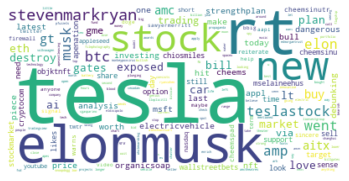

In [6]:
#Removing NaN Values
df.dropna(inplace = True)
#Creating the text variable
text = " ".join(texto for texto in df.temporal)
#Dropping HTTPS word and the name of the hashtag of the words in the cloud 
lista=[]
for i in text.split():
    if not i in (hashtag[1:].lower(),'https'):
        lista.append(i)
        #print(i)
text= " ".join(texto for texto in lista)
text
# Creating word_cloud with text as argument in .generate() method
wordcloud = WordCloud(collocations = False, background_color = 'white').generate(text)
# Display the generated Word Cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()